# Inference: Simple-Importance-Sampling MCMC

# Goodwin oscillator

### Tempered at T=0.5

In [1]:
import os
os.chdir("..")
import pints
import pints.toy
import pints.plot
import matplotlib.pyplot as plt
import numpy as np

class TemperedLogPosterior(pints.LogPDF):
    def __init__(self, temperature, log_posterior):
        self._temperature = temperature
        self._log_posterior = log_posterior
        
    def __call__(self, x):
        return (1.0 - self._temperature) * self._log_posterior(x)

    def n_parameters(self):
        return self._log_posterior.n_parameters()

model = pints.toy.GoodwinOscillatorModel()
real_parameters = model.suggested_parameters()
print(real_parameters)
times = model.suggested_times()
values = model.simulate(real_parameters, times)
noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.KnownNoiseLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

temperature = 0.5
log_posterior_t = TemperedLogPosterior(temperature=temperature, log_posterior=log_posterior)

# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCSampling(log_posterior_t, 3, x0)
mcmc.set_max_iterations(5000)
mcmc.set_log_to_screen(False)

print('Running')
chains = mcmc.run()
print('Done!')

[ 2.    4.    0.12  0.08  0.1 ]
Running
Done!


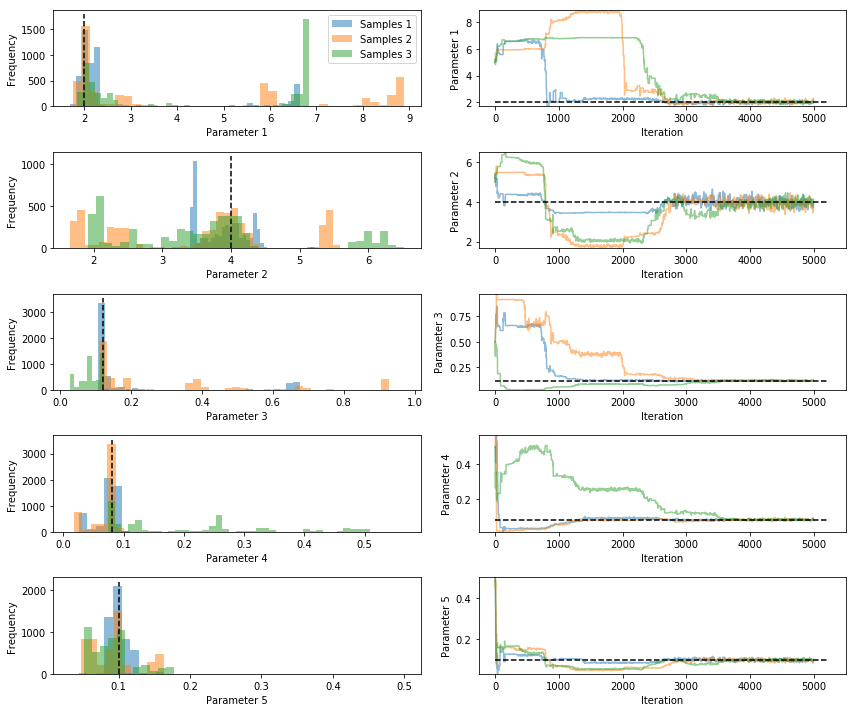

In [2]:
pints.plot.trace(chains, ref_parameters=real_parameters)
plt.show()

ESS = 2979


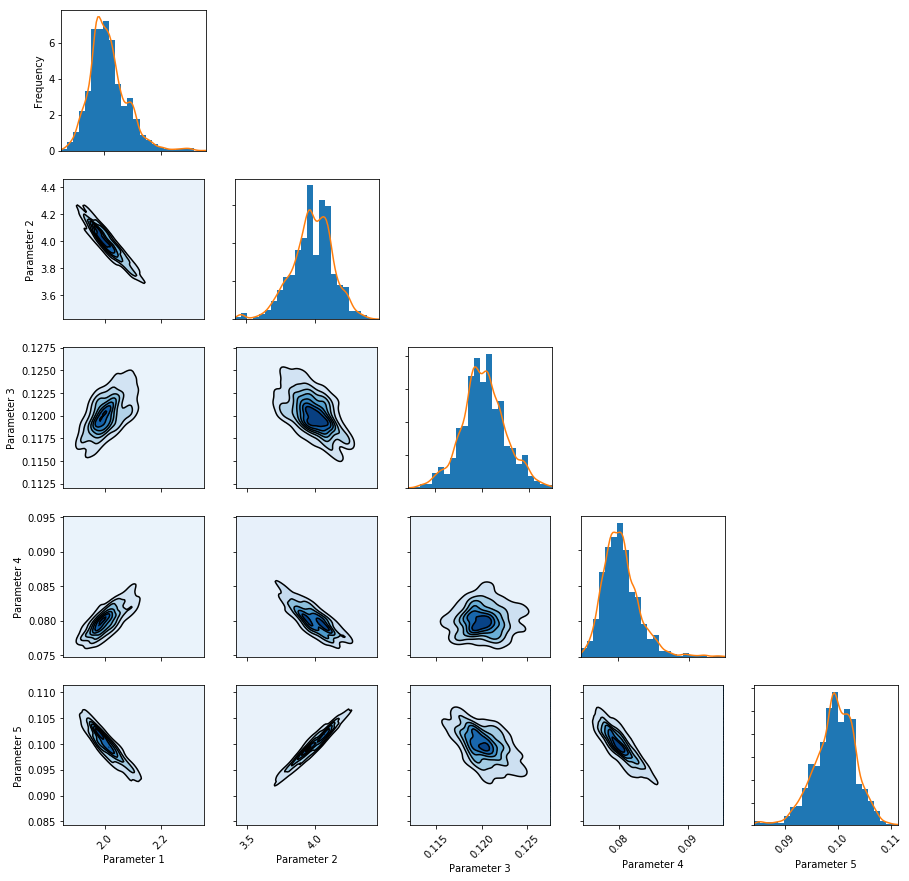

In [3]:
# Get samples
samples=np.vstack(chains)

import scipy.misc
log_weight = [temperature * log_posterior(sample) for sample in samples]
w = np.exp(log_weight - scipy.misc.logsumexp(log_weight))
def ess(w):
    return int(1.0 / np.sum(w**2))
print('ESS = ' + str(ess(w)))
idx = np.random.choice(len(w), size=ess(w), p=w)
samples1 = samples[idx, :]

# Look at distribution in chain 0
pints.plot.pairwise(samples1, kde=True)

# Show graphs
plt.show()

### Untempered (standard adaptive MCMC)

[ 2.    4.    0.12  0.08  0.1 ]
Running
Done!


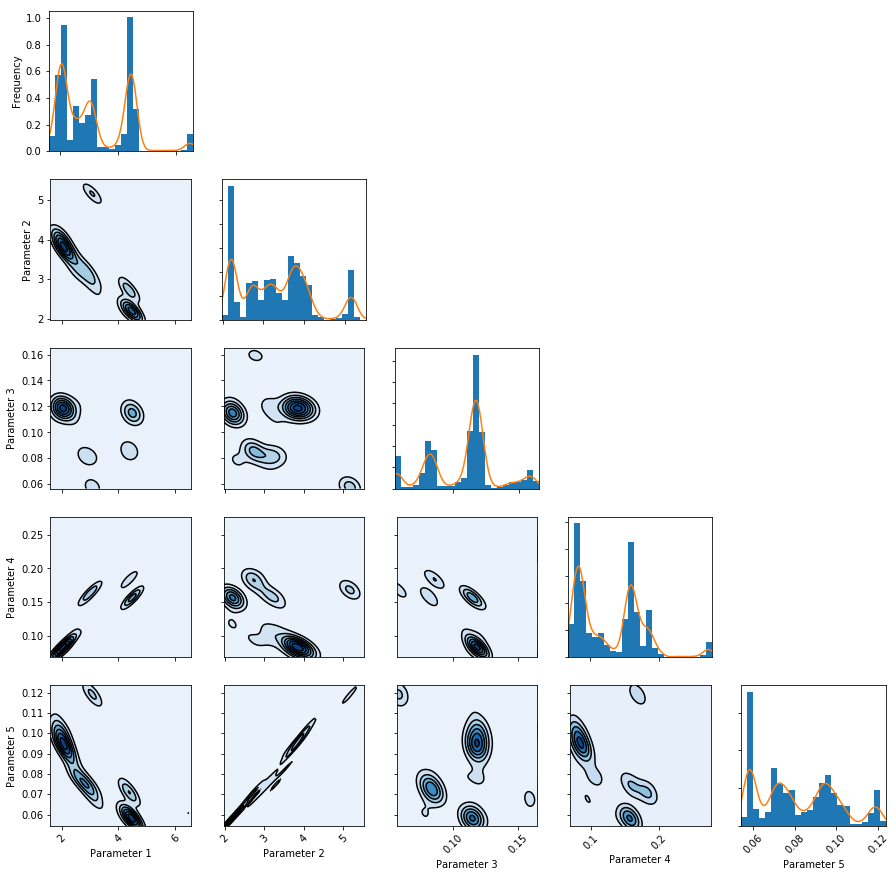

In [4]:
model = pints.toy.GoodwinOscillatorModel()
real_parameters = model.suggested_parameters()
print(real_parameters)
times = model.suggested_times()
values = model.simulate(real_parameters, times)
noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.KnownNoiseLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

temperature = 0.0
log_posterior_t = TemperedLogPosterior(temperature=temperature, log_posterior=log_posterior)

# Run MCMC on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
mcmc = pints.MCMCSampling(log_posterior_t, 3, x0)
mcmc.set_max_iterations(5000)
mcmc.set_log_to_screen(False)

print('Running')
chains = mcmc.run()
print('Done!')

# Discard warm up
chains = chains[:, 2000:, :]

# Get samples
samples=np.vstack(chains)

# Look at distribution in chain 0
pints.plot.pairwise(samples, kde=True)

# Show graphs
plt.show()